<a href="https://colab.research.google.com/github/adalves-ufabc/2021.QS-PLN/blob/main/2021_Q1_PLN_Notebook_30.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Processamento de Linguagem Natural [2021.Q1]**
Prof. Alexandre Donizeti Alves

### **Sumarização Automática de Textos**

Todos nós interagimos com aplicações que usam resumo de texto. Muitas dessas aplicações são para plataformas que publicam artigos de notícias diárias, entretenimento, esportes etc. Com nossa agenda lotada, preferimos ler o resumo desses artigos antes de decidir pela leitura do artigo inteiro. A leitura de um resumo nos ajuda a identificar a área de interesse e nos dá um breve contexto da história.

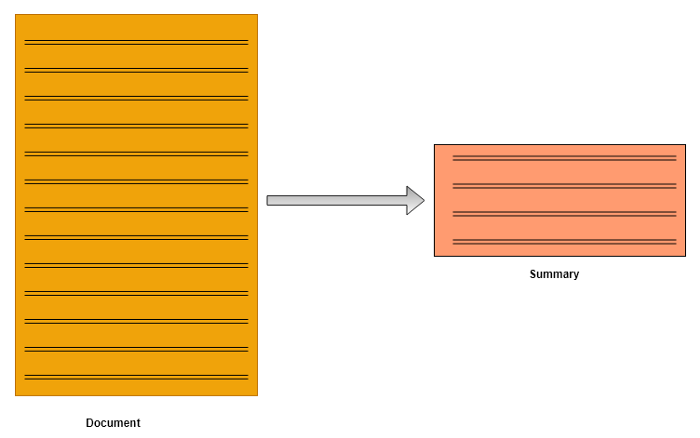

**Sumarização** pode ser definida como a tarefa de produzir um resumo conciso e fluente, preservando as informações-chave e o significado geral.

### **Impacto**

Os sistemas de sumarização geralmente possuem evidências adicionais que podem ser usadas para especificar os tópicos mais importantes do(s) documento(s). Por exemplo, ao resumir *blogs*, há discussões ou comentários após a postagem do *blog* que são boas fontes de informação para determinar quais partes do *blog* são críticas e interessantes.

>
Na sumarização de artigos científicos, há uma quantidade considerável de informações, como artigos citados e informações de conferências, que podem ser aproveitadas para identificar frases importantes no artigo original.

### **Como funciona a Sumarização de Textos**

Em geral, existem dois tipos de sumarização: **abstrativa** e **extrativa**.

* **Abstrativa**: os métodos abstrativos selecionam palavras com base na compreensão semântica, mesmo que essas palavras não apareçam nos documentos original. Tem como objetivo produzir material importante de uma nova maneira. Eles interpretam e examinam o texto usando técnicas avançadas de PLN para gerar um novo texto mais curto que transmita as informações mais importantes do texto original.

Pode ser correlacionado à maneira como o ser humano lê um artigo de texto ou uma postagem de *blog* e, em seguida, resume com suas próprias palavras.

>
> ***Input document → understand context → semantics → create own summary***.

>
>

* **Extrativa**: Os métodos extrativos tentam resumir os artigos selecionando um subconjunto de palavras que retém os pontos mais importantes.

Esta abordagem pondera a parte importante das sentenças e usa a mesma para formar o resumo. Diferentes algoritmos e técnicas são usados para definir pesos para as sentenças e posteriormente classificá-las com base na importância e semelhança entre si.

>
> ***Input document → sentences similarity → weight sentences → select sentences with higher rank***.

>
A sumarização abstrativa requer uma compreensão mais profunda do texto em comparação com a abordagem extrativa.

Sumarizações puramente extrativas muitas vezes fornecem melhores resultados em comparação com sumarizações abstrativas. Isso ocorre devido ao fato de que os métodos de sumarização abstrativa lidam com problemas como a representação semântica, inferência e geração de linguagem natural que é relativamente mais difícil do que abordagens baseadas em dados, como extração de frases.

Existem muitas técnicas disponíveis para gerar sumarização extrativa. Para simplificar, usaremos uma abordagem de aprendizado não supervisionado para encontrar a similaridade das sentenças e classificá-las. Um benefício disso será que você não precisa treinar e construir um modelo antes de começar a usá-lo em seu projeto.

É bom entender a **similaridade por cosseno** para fazer o melhor uso do código que você verá. A similaridade por cosseno é uma medida da similaridade entre dois vetores num espaço vetorial que avalia o valor do cosseno do ângulo compreendido entre eles. Visto que representaremos nossas sentenças como um conjunto de vetores, podemos usá-lo para encontrar a similaridade entre as sentenças. Ele mede o cosseno do ângulo entre os vetores. O ângulo será 0 se as sentenças forem semelhantes.

A seguir é apresentado o código para gerar a sumarização de textos:

>***Input article → split into sentences → remove stop words → build a similarity matrix → generate rank based on matrix → pick top N sentences for summary***.

In [1]:
# 1. Import all necessary libraries

import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.cluster.util import cosine_distance

import numpy as np
import networkx as nx

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
# 2. Generate clean sentences

def read_article(file_name):
  file = open(file_name, "r")
  filedata = file.readlines()
  article = filedata[0].split(". ")
  
  sentences = []   
  for sentence in article:
    print(sentence)
    sentences.append(sentence.replace("[^a-zA-Z]", " ").split(" "))
  
  sentences.pop() 
    
  return sentences 

In [3]:
# 3. Similarity matrix

def sentence_similarity(sent1, sent2, stopwords=None):
    if stopwords is None:
        stopwords = []
 
    sent1 = [w.lower() for w in sent1]
    sent2 = [w.lower() for w in sent2]
 
    all_words = list(set(sent1 + sent2))
 
    vector1 = [0] * len(all_words)
    vector2 = [0] * len(all_words)
 
    # build the vector for the first sentence
    for w in sent1:
        if w in stopwords:
            continue
        vector1[all_words.index(w)] += 1
 
    # build the vector for the second sentence
    for w in sent2:
        if w in stopwords:
            continue
        vector2[all_words.index(w)] += 1
 
    return 1 - cosine_distance(vector1, vector2)    

def build_similarity_matrix(sentences, stop_words):

    # create an empty similarity matrix
    similarity_matrix = np.zeros((len(sentences), len(sentences)))
 
    for idx1 in range(len(sentences)):
        for idx2 in range(len(sentences)):
            if idx1 == idx2: #ignore if both are same sentences
                continue 
            similarity_matrix[idx1][idx2] = sentence_similarity(sentences[idx1], sentences[idx2], stop_words)
    
    return similarity_matrix    

In [4]:
# 4. Generate Summary Method

def generate_summary(file_name, top_n=5):
    stop_words = stopwords.words('english')
    summarize_text = []    
    
    # Step 1 - Read text and tokenize
    sentences =  read_article(file_name) 

    # Step 2 - Generate Similary Martix across sentences
    sentence_similarity_martix = build_similarity_matrix(sentences, stop_words)    

    # Step 3 - Rank sentences in similarity martix
    sentence_similarity_graph = nx.from_numpy_array(sentence_similarity_martix)
    scores = nx.pagerank(sentence_similarity_graph)  
    
    # Step 4 - Sort the rank and pick top sentences
    ranked_sentence = sorted(((scores[i],s) for i,s in enumerate(sentences)), reverse=True)    
    print("\nIndexes of top ranked_sentence order are ", ranked_sentence)    

    for i in range(top_n):
      summarize_text.append(" ".join(ranked_sentence[i][1]))

    # Step 5 - Offcourse, output the summarize texr
    print("\nSummarize Text: \n", ". ".join(summarize_text))

In [5]:
generate_summary("/content/msft.txt", 3)

In an attempt to build an AI-ready workforce, Microsoft announced Intelligent Cloud Hub which has been launched to empower the next generation of students with AI-ready skills
Envisioned as a three-year collaborative program, Intelligent Cloud Hub will support around 100 institutions with AI infrastructure, course content and curriculum, developer support, development tools and give students access to cloud and AI services
As part of the program, the Redmond giant which wants to expand its reach and is planning to build a strong developer ecosystem in India with the program will set up the core AI infrastructure and IoT Hub for the selected campuses
The company will provide AI development tools and Azure AI services such as Microsoft Cognitive Services, Bot Services and Azure Machine Learning.According to Manish Prakash, Country General Manager-PS, Health and Education, Microsoft India, said, "With AI being the defining technology of our time, it is transforming lives and industry and 

**Mais informações:**

> [Understand Text Summarization and create your own summarizer in python](https://towardsdatascience.com/understand-text-summarization-and-create-your-own-summarizer-in-python-b26a9f09fc70)